#**1. Entorno CartPole**

In [1]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

env = gym.envs.make("CartPole-v0")

In [2]:
print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space.shape))
print("Reward range is {} ".format(env.reward_range))
print("Maximum number of episodes by step is {}".format(env.spec.max_episode_steps))
print("Reward threshold is {}".format(env.spec.reward_threshold))

Action space is Discrete(2) 
Observation space is (4,) 
Reward range is (-inf, inf) 
Maximum number of episodes by step is 200
Reward threshold is 195.0


In [5]:
#Visualizamos el entorno
for i_episode in range(10):
    obs = env.reset()
    for t in range(100):
        print(obs)
        action = env.action_space.sample() #Tomamos una acción
        obs, reward, done, info = env.step(action) #ejecución de la acción elegida
        if done:
            print("Episode finished after {} timesteps".format(t+1)) 
            break


[-0.02509271  0.03545034 -0.00406751  0.03728048]
[-0.0243837  -0.15961304 -0.0033219   0.3286773 ]
[-0.02757596 -0.35468755  0.00325165  0.6203108 ]
[-0.03466972 -0.54985476  0.01565787  0.91401606]
[-0.04566681 -0.74518497  0.03393819  1.21157867]
[-0.06057051 -0.9407282   0.05816976  1.51470053]
[-0.07938507 -0.74635655  0.08846377  1.24072845]
[-0.0943122  -0.55247473  0.11327834  0.97701739]
[-0.1053617  -0.74891847  0.13281869  1.3030271 ]
[-0.12034007 -0.94545135  0.15887923  1.63416399]
[-0.1392491  -1.14204146  0.19156251  1.97184935]
Episode finished after 11 timesteps
[ 0.03022547 -0.02932387 -0.04662758 -0.04109496]
[ 0.02963899 -0.22374725 -0.04744948  0.2365196 ]
[ 0.02516404 -0.41816032 -0.04271909  0.51386606]
[ 0.01680084 -0.22246357 -0.03244177  0.20803316]
[ 0.01235157 -0.41710697 -0.02828111  0.49030842]
[ 0.00400943 -0.22159772 -0.01847494  0.18884827]
[-0.00042253 -0.02621639 -0.01469797 -0.10960503]
[-0.00094686  0.16911306 -0.01689007 -0.4068886 ]
[ 0.00243541 -

# **2. Construcción de una DQN**

In [6]:
class DQN(torch.nn.Module):
    
    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        super(DQN, self).__init__()
        self.device = device
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        ### Construcción de la red neuronal
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 64, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(16, self.n_outputs, bias=True))
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        
       
        if self.device == 'cuda':
            self.model.cuda()
            
    
    
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  
        else:
            qvals = self.get_qvals(state)  
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.model(state_t)

In [7]:
from collections import namedtuple, deque

In [8]:
class experienceReplayBuffer:

    def __init__(self, memory_size=20000, burn_in=100):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

In [9]:
from copy import deepcopy, copy

In [10]:
class DQNAgent:
    
    def __init__(self, env, dnnetwork, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = env
        self.dnnetwork = dnnetwork
        self.target_network = deepcopy(dnnetwork) 
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 
        self.reward_threshold = self.env.spec.reward_threshold 
        self.initialize()
    
    
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
        
    
    ## Tomar nueva acción
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            
            action = self.env.action_space.sample() 
        else:
            
            action = self.dnnetwork.get_action(self.state0, eps)
            self.step_count += 1
            
        # Realización de la acción y obtención del nuevo estado y la recompensa
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) 
        self.state0 = new_state.copy()
        
        if done:
            self.state0 = env.reset()
        return done

    
        
    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=10,
              dnn_sync_frequency=5000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
               
                # Actualizamos la red principal según la frecuencia establecida
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                # Sincronizamos red principal y red objetivo según la frecuencia establecida
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.dnnetwork.state_dict())
                    self.sync_eps.append(episode)
                    
                
                if gamedone:                   
                    episode += 1
                    self.training_rewards.append(self.total_reward) # guardamos las recompensas obtenidas
                    self.update_loss = []
                    mean_rewards = np.mean(   # calculamos la media de recompensa de los últimos X episodios
                        self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)

                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    # Comprobamos que todavía quedan episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break
                    
                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego  
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break
                    
                    # Actualizar epsilon según la velocidad de decaimiento fijada
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)
                    
                
    ## Cálculo de la pérdida                   
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards).to(device=self.dnnetwork.device) 
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(
            device=self.dnnetwork.device)
        dones_t = torch.ByteTensor(dones).to(device=self.dnnetwork.device)
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.dnnetwork.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        # Calculamos ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        # Calculamos la pérdida
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        return loss
    

    
    def update(self):
        self.dnnetwork.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.dnnetwork.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        if self.dnnetwork.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())
            


    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.axhline(self.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()

In [11]:
lr = 0.001            
mem_size= 100000  
max_episodes = 5000   
epsilon = 1           
epsilon_decay = .99   
gamma = 0.99          
batch_size = 32       
burn_in = 1000        
update_dnn = 1           
sync_dnn = 2500  

In [12]:
buffer = experienceReplayBuffer(memory_size=mem_size, burn_in=burn_in)


In [13]:
dqn = DQN(env, learning_rate=lr)

In [14]:
agent = DQNAgent(env, dqn, buffer, epsilon, epsilon_decay, batch_size)


In [15]:
agent.train(gamma=gamma, max_episodes=max_episodes, batch_size=batch_size, dnn_update_frequency=update_dnn, dnn_sync_frequency=sync_dnn)

Filling replay buffer...
Training...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


Episode 974 Mean Rewards 195.32 Epsilon 0.01		
Environment solved in 974 episodes!


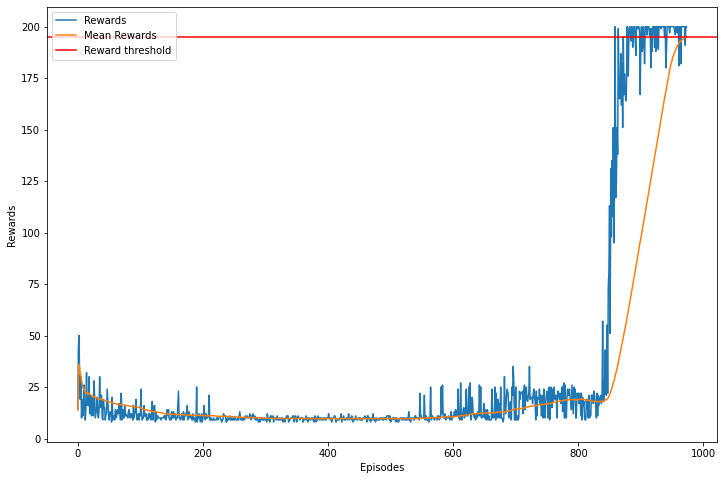

In [16]:
agent.plot_rewards()